# AutoGluon Time Series - Forecasting Quick Start

- https://github.com/autogluon/autogluon
- https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-quick-start.html

Via a simple fit() call, AutoGluon can train and tune

- simple forecasting models (e.g., ARIMA, ETS, Theta),

- powerful deep learning models (e.g., DeepAR, Temporal Fusion Transformer),

- tree-based models (e.g., LightGBM),

- an ensemble that combines predictions of other models

to produce multi-step ahead probabilistic forecasts for univariate time series data.

This tutorial demonstrates how to quickly start using AutoGluon to generate hourly forecasts for the [M4 forecasting competition dataset](https://www.sciencedirect.com/science/article/pii/S0169207019301128).

## Data

We load a subset of the M4 hourly dataset as a pandas.DataFrame

In [ ]:
import pandas as pd

df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df.head()

,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


To use autogluon.timeseries, we will only need the following two classes:

- TimeSeriesDataFrame stores a dataset consisting of multiple time series.

- TimeSeriesPredictor takes care of fitting, tuning and selecting the best forecasting models, as well as generating new forecasts.

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

AutoGluon expects time series data in [long format](https://doc.dataiku.com/dss/latest/time-series/data-formatting.html#long-format). Each row of the data frame contains a single observation (timestep) of a single time series represented by

- unique ID of the time series ("item_id") as int or str

- timestamp of the observation ("timestamp") as a pandas.Timestamp or compatible format

- numeric value of the time series ("target")

The raw dataset should always follow this format with at least three columns for unique ID, timestamp, and target value, but the names of these columns can be arbitrary. It is important, however, that we provide the names of the columns when constructing a TimeSeriesDataFrame that is used by AutoGluon. AutoGluon will raise an exception if the data doesn’t match the expected format.

In [ ]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

We refer to each individual time series stored in a TimeSeriesDataFrame as an item. For example, items might correspond to different products in demand forecasting, or to different stocks in financial datasets. This setting is also referred to as a panel of time series. Note that this is not the same as multivariate forecasting — AutoGluon generates forecasts for each time series individually, without modeling interactions between different items (time series).

## Training

To forecast future values of the time series, we need to create a TimeSeriesPredictor object.

Models in autogluon.timeseries forecast time series multiple steps into the future. We choose the number of these steps — the prediction length (also known as the forecast horizon) — depending on our task. For example, our dataset contains time series measured at hourly frequency, so we set prediction_length = 48 to train models that forecast up to 48 hours into the future.

We instruct AutoGluon to save trained models in the folder ./autogluon-m4-hourly. We also specify that AutoGluon should rank models according to [mean absolute scaled error (MASE)](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error), and that data that we want to forecast is stored in the column "target" of the TimeSeriesDataFrame.

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/home/mgj/workspace/notebooks/autogluon/autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Nov 5 00:21:55 UTC 2024
CPU Count:          12
GPU Count:          1
Memory Avail:       25.45 GB / 31.35 GB (81.2%)
Disk Space Avail:   808.39 GB / 1006.85 GB (80.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	-0.8121       = Validation score (-MASE)
	1.13    s     = Training runtime
	7.80    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 264.0s of the 527.9s of remaining time.
	-2.2029       = Validation score (-MASE)
	57.92   s     = Training runtime
	0.16    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'Chronos[bolt_small]': 0.74, 'DirectTabular': 0.04, 'ETS': 0.02, 'RecursiveTabular': 0.19}
	-0.7915       = Validation score (-MASE)
	0.50    s     = Training runtime
	20.71   s     = Validation (prediction) runtime
Training complete. Models trained: ['Naive', 'SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'ETS', 'Theta', 'Chronos[bolt_small]', 'TemporalFusionTransformer', 'WeightedEnsemble']
Total runtime: 129.58 s
Best model: WeightedEnsemble
Best model score: -0.7915


<autogluon.timeseries.predictor.TimeSeriesPredictor>

Here we used the "medium_quality" presets and limited the training time to 10 minutes (600 seconds). The presets define which models AutoGluon will try to fit. For medium_quality presets, these are simple baselines (Naive, SeasonalNaive), statistical models (ETS, Theta), tree-based models based on LightGBM (RecursiveTabular, DirectTabular), a deep learning model TemporalFusionTransformer, and a weighted ensemble combining these. Other available presets for TimeSeriesPredictor are "fast_training", "high_quality" and "best_quality". Higher quality presets will usually produce more accurate forecasts but take longer to train.

Inside fit(), AutoGluon will train as many models as possible within the given time limit. Trained models are then ranked based on their performance on an internal validation set. By default, this validation set is constructed by holding out the last prediction_length timesteps of each time series in train_data.

# Forecast

We can now use the fitted TimeSeriesPredictor to forecast the future time series values. By default, AutoGluon will make forecasts using the model that had the best score on the internal validation set. The forecast always includes predictions for the next prediction_length timesteps, starting from the end of each time series in train_data.

In [ ]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  622.191633  598.352106  606.819971  612.956287   
        1750-01-30 05:00:00  563.195006  537.393103  546.954576  553.249349   
        1750-01-30 06:00:00  521.683860  494.428072  504.041315  511.148911   
        1750-01-30 07:00:00  490.505591  461.721706  471.825668  479.072630   
        1750-01-30 08:00:00  465.746830  435.351538  445.591088  453.185296   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  617.685092  622.191633  626.836042  631.409826   
        1750-01-30 05:00:00  558.428323  563.195006  567.606607  572.418778   
        1750-01-30 06:00:00  516.678754  521.683860  526.831450  532.170242   
        1750-01-30 07:00:00  485.098750  490.505591  496.272696  502.215465   
        1750-01-30 08:00:00  459.950173  465.746830  471.472605  477.611101   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  636.792800  644.542990  
        1750-01-30 05:00:00  578.155922  586.702938  
        1750-01-30 06:00:00  538.339738  547.689556  
        1750-01-30 07:00:00  508.974322  519.732682  
        1750-01-30 08:00:00  485.099102  495.941271

AutoGluon produces a probabilistic forecast: in addition to predicting the mean (expected value) of the time series in the future, models also provide the quantiles of the forecast distribution. The quantile forecasts give us an idea about the range of possible outcomes. For example, if the "0.1" quantile is equal to 500.0, it means that the model predicts a 10% chance that the target value will be below 500.0.

We will now visualize the forecast and the actually observed values for one of the time series in the dataset. We plot the mean forecast, as well as the 10% and 90% quantiles to show the range of potential outcomes.

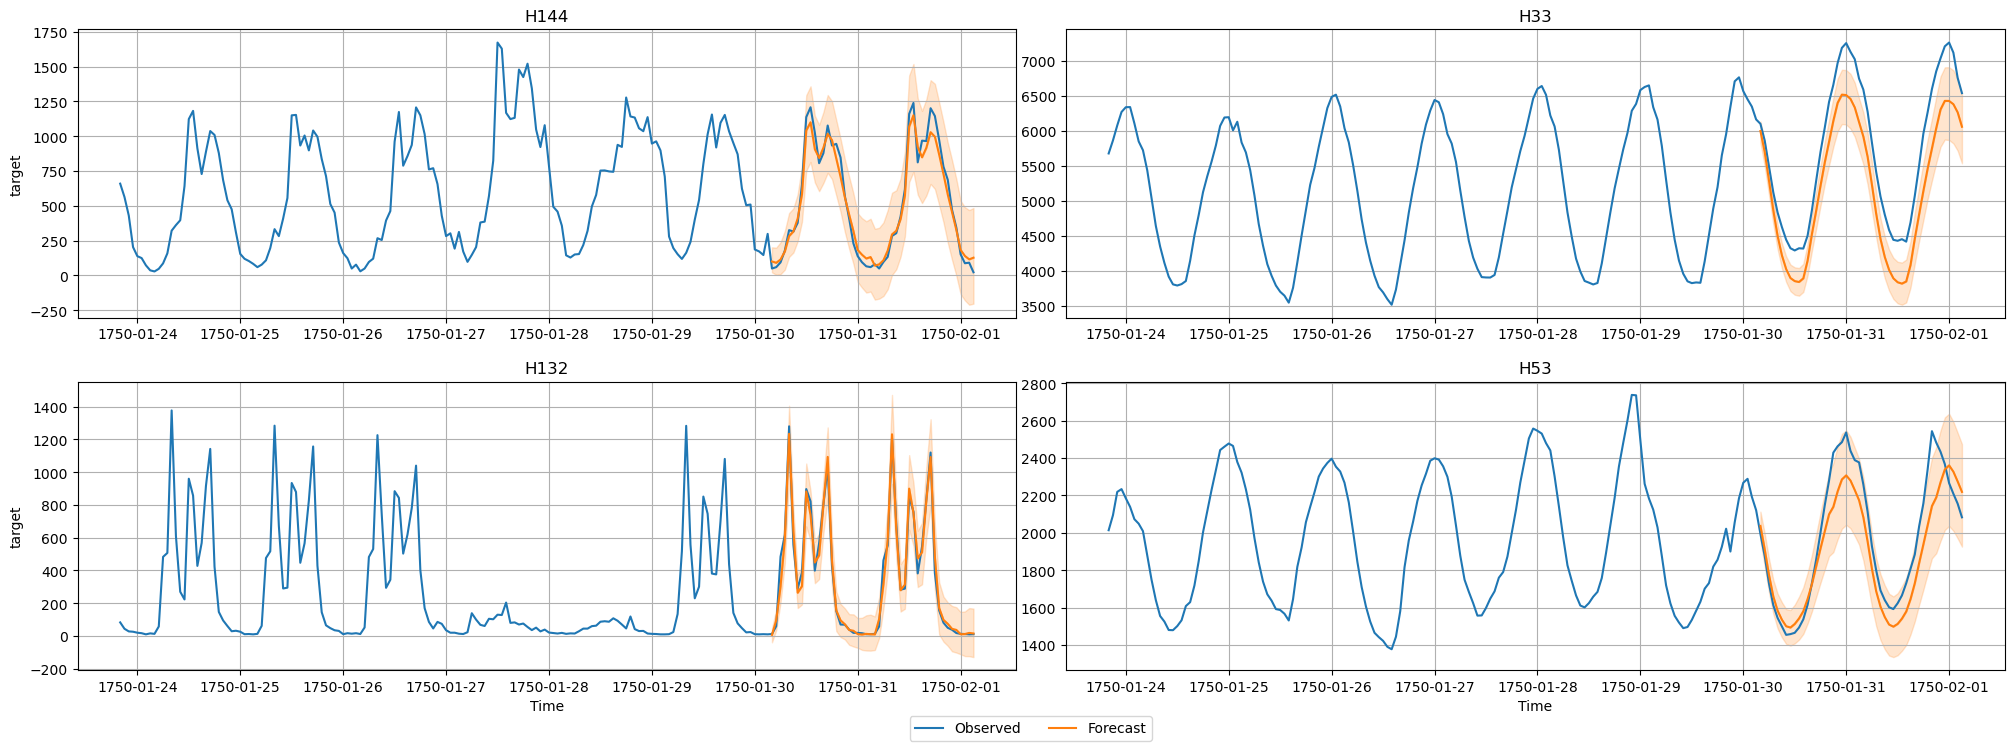

In [ ]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4);

## Evaluating the performance of different models

We can view the performance of each model AutoGluon has trained via the leaderboard() method. We provide the test data set to the leaderboard function to see how well our fitted models are doing on the unseen test data. The leaderboard also includes the validation scores computed on the internal validation dataset.

Note the test data includes both the forecast horizon (last prediction_length values of each time series) as well as the historic data (all except the last prediction_last values).

In AutoGluon leaderboards, higher scores always correspond to better predictive performance. Therefore our MASE scores are multiplied by -1, such that higher "negative MASE"s correspond to more accurate forecasts.

In [ ]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.697903,-0.791454,19.735360,20.706966,0.501418,9
1,Chronos[bolt_small],-0.725739,-0.812070,1.346272,7.802005,1.127583,7
2,RecursiveTabular,-0.862797,-0.933874,0.837376,0.913780,6.029442,3
3,SeasonalNaive,-1.022854,-1.216909,0.136829,0.104871,0.077978,2
4,DirectTabular,-1.605700,-1.292127,0.477215,0.234093,4.467018,4
5,ETS,-1.806131,-1.966061,17.068272,11.757088,0.078060,5
6,Theta,-1.905365,-2.142531,33.961334,35.318911,0.068901,6
7,TemporalFusionTransformer,-1.923948,-2.202893,0.219084,0.156128,57.919999,8
8,Naive,-6.696079,-6.662942,0.092896,2.345010,0.083520,1
